# 02_exploratory_analysis.ipynb
**An Interpretable ML Framework for Estimating Postmortem Interval (PMI)** **Notebook 2 — Automated EDA and Feature Engineering**

Install dependencies

In [ ]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn

Imports & config

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import KBinsDiscretizer


sns.set_theme(style="whitegrid")
pd.options.display.float_format = "{:.3f}".format
RND = 42

Load dataset

In [ ]:
data_dir = "data"

In [ ]:
files = sorted([f for f in os.listdir(data_dir) if f.startswith("synthetic_pmi_dataset_N10000_seed42_20251107T153017Z") and f.endswith(".csv")])
latest = os.path.join(data_dir, files[-1]) if files else None
print("Using dataset:", latest)

df = pd.read_csv(latest)
print(df.shape)
df.head()

Using dataset: data/synthetic_pmi_dataset_N10000_seed42_20251107T153017Z.csv
(10000, 16)


,pmi_hours,true_pmi_hours,body_temp_c,ambient_temp_c,humidity_pct,surface_type,clothing_insulation,clothing_wet,bmi,rigor_stage,livor_stage,decomposition_score,insect_activity_index,wound_present,contact_area_pct,sun_exposure
0,12.364,14.078,36.261,29.910,67,indoors,2.723,0,26.395,3,2,0.007,0.000,0,46.870,0
1,22.651,22.318,31.732,18.971,36,indoors,2.016,0,17.381,1,2,0.845,0.000,0,46.390,0
2,36.395,28.060,26.901,14.288,42,indoors,0.908,0,19.892,4,2,0.000,0.000,0,87.300,0
3,9.303,6.132,36.163,31.247,78,indoors,1.419,1,29.409,2,2,0.000,0.000,0,48.480,0
4,9.337,9.894,34.676,20.643,61,concrete,0.815,0,27.911,2,1,0.892,1.889,0,48.020,0


Basic data inspection

In [ ]:
df.info()
print("\nMissing values per column:\n", df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pmi_hours              10000 non-null  float64
 1   true_pmi_hours         10000 non-null  float64
 2   body_temp_c            10000 non-null  float64
 3   ambient_temp_c         10000 non-null  float64
 4   humidity_pct           10000 non-null  int64  
 5   surface_type           10000 non-null  object 
 6   clothing_insulation    10000 non-null  float64
 7   clothing_wet           10000 non-null  int64  
 8   bmi                    10000 non-null  float64
 9   rigor_stage            10000 non-null  int64  
 10  livor_stage            10000 non-null  int64  
 11  decomposition_score    10000 non-null  float64
 12  insect_activity_index  10000 non-null  float64
 13  wound_present          10000 non-null  int64  
 14  contact_area_pct       10000 non-null  float64
 15  sun

Summary statistics

In [ ]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
pmi_hours,10000.000,29.868,29.727,0.000,8.618,21.214,41.463,247.195
true_pmi_hours,10000.000,29.814,29.592,0.001,8.358,20.974,41.284,240.000
body_temp_c,10000.000,30.731,5.197,4.508,27.616,31.917,34.915,40.323
ambient_temp_c,10000.000,19.982,5.997,-2.894,15.886,19.965,24.032,41.220
humidity_pct,10000.000,54.535,19.608,10.000,41.000,55.000,68.000,100.000
clothing_insulation,10000.000,1.252,0.904,0.000,0.516,1.196,1.871,5.000
clothing_wet,10000.000,0.081,0.272,0.000,0.000,0.000,0.000,1.000
bmi,10000.000,25.096,4.883,15.000,21.696,25.029,28.390,45.000
rigor_stage,10000.000,2.297,1.279,0.000,1.000,2.000,3.000,4.000
livor_stage,10000.000,1.911,1.011,0.000,1.000,2.000,3.000,3.000


Target variable distribution

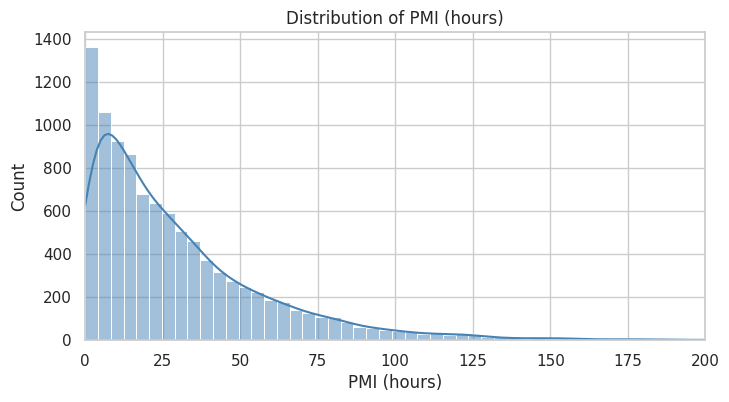

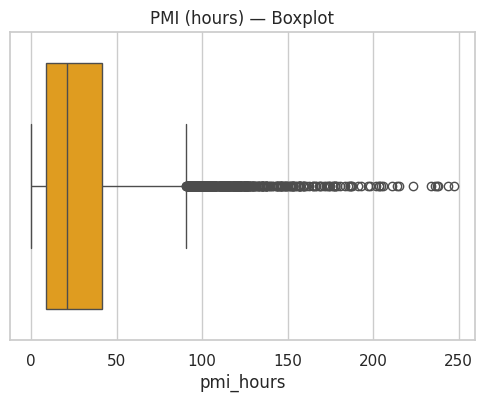

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["pmi_hours"], bins=60, kde=True, color="steelblue")
plt.title("Distribution of PMI (hours)")
plt.xlabel("PMI (hours)")
plt.ylabel("Count")
plt.xlim(0, 200)
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df["pmi_hours"], color="orange")
plt.title("PMI (hours) — Boxplot")
plt.show()

# Relationship: body temperature vs PMI

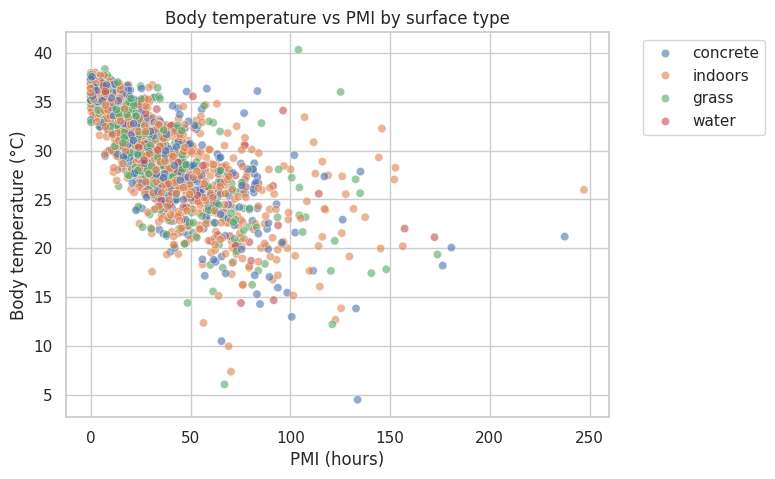

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df.sample(2000, random_state=RND),
    x="pmi_hours",
    y="body_temp_c",
    hue="surface_type",
    alpha=0.6
  )
plt.title("Body temperature vs PMI by surface type")
plt.xlabel("PMI (hours)")
plt.ylabel("Body temperature (°C)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Correlation analysis

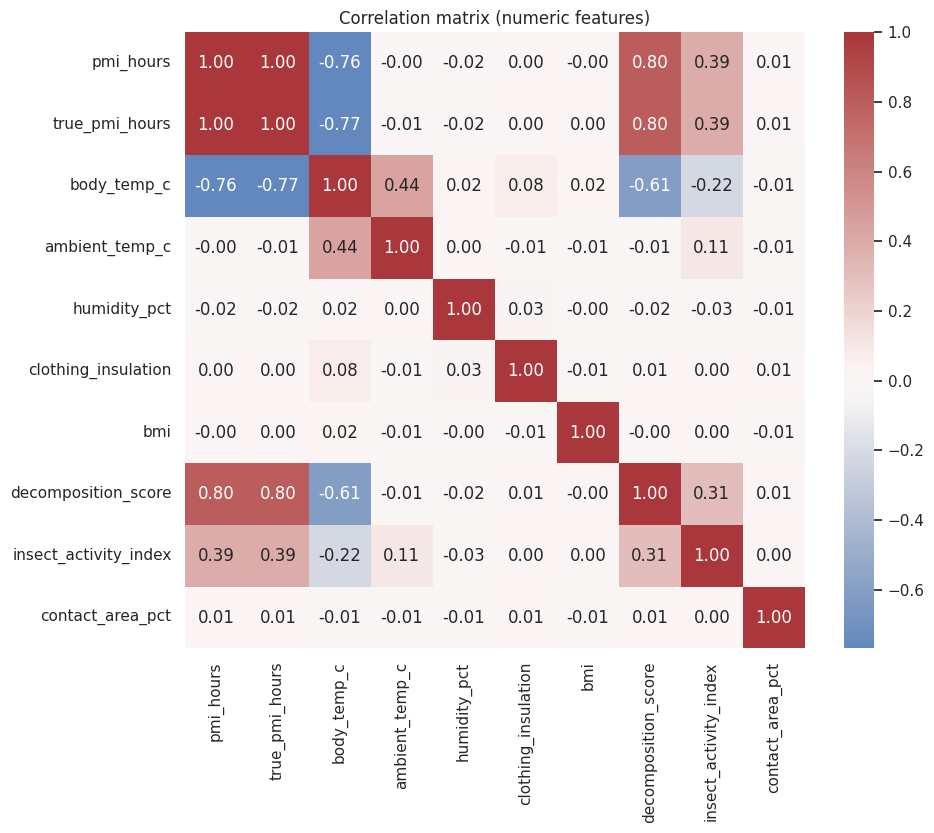

,pmi_hours
pmi_hours,1.000
true_pmi_hours,0.995
decomposition_score,0.800
insect_activity_index,0.393
contact_area_pct,0.009
clothing_insulation,0.002
bmi,-0.000
ambient_temp_c,-0.004
humidity_pct,-0.017
body_temp_c,-0.763


In [ ]:
num_cols = [
    "pmi_hours","true_pmi_hours","body_temp_c","ambient_temp_c","humidity_pct",
    "clothing_insulation","bmi","decomposition_score","insect_activity_index","contact_area_pct"
  ]

plt.figure(figsize=(10,8))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()

corr["pmi_hours"].sort_values(ascending=False)

Relationships with PMI

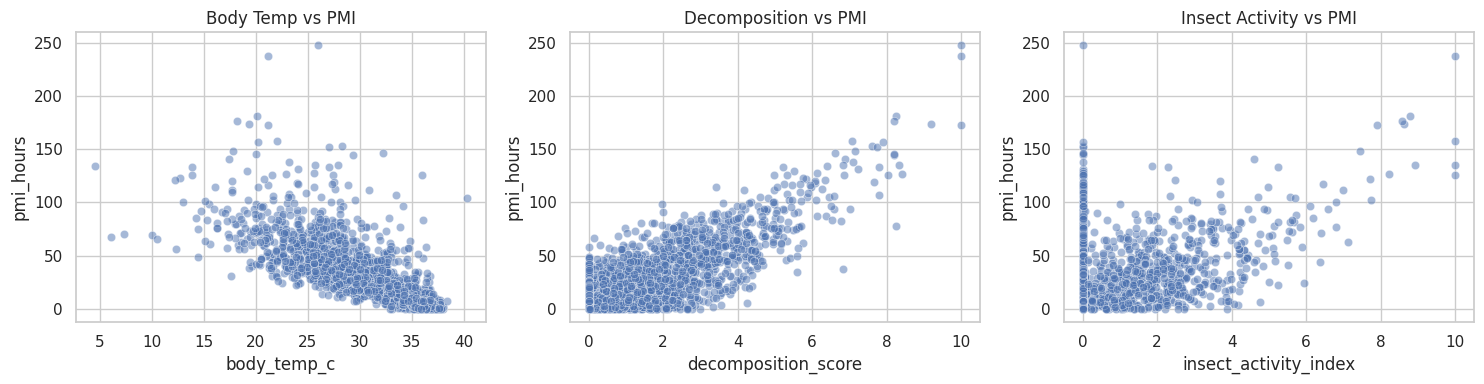

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.scatterplot(data=df.sample(2000, random_state=RND), x="body_temp_c", y="pmi_hours", ax=axs[0], alpha=0.5)
sns.scatterplot(data=df.sample(2000, random_state=RND), x="decomposition_score", y="pmi_hours", ax=axs[1], alpha=0.5)
sns.scatterplot(data=df.sample(2000, random_state=RND), x="insect_activity_index", y="pmi_hours", ax=axs[2], alpha=0.5)
axs[0].set_title("Body Temp vs PMI")
axs[1].set_title("Decomposition vs PMI")
axs[2].set_title("Insect Activity vs PMI")
plt.tight_layout()
plt.show()

Group comparisons

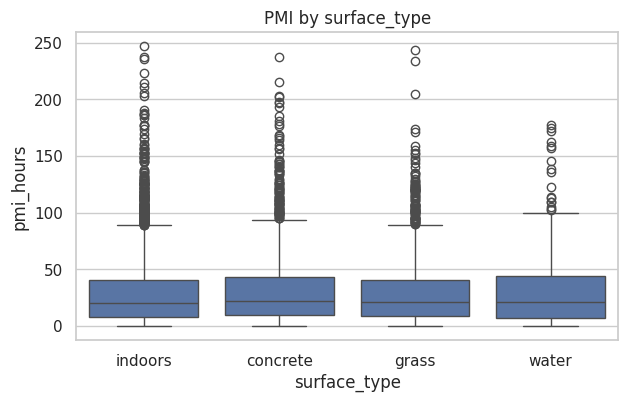

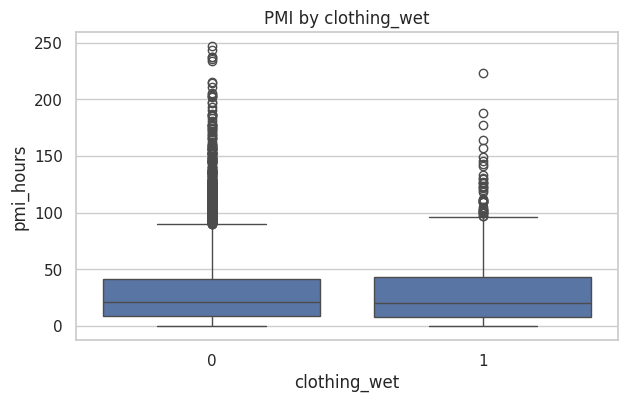

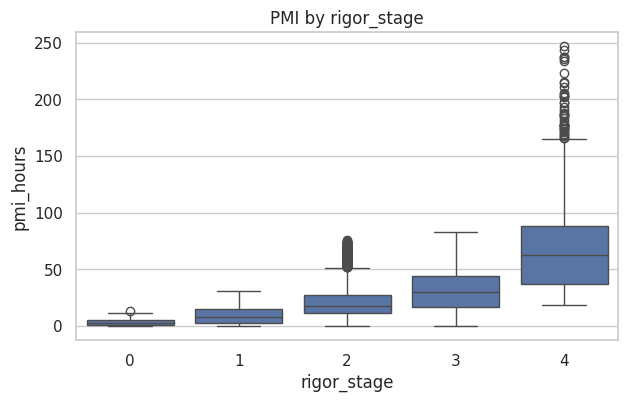

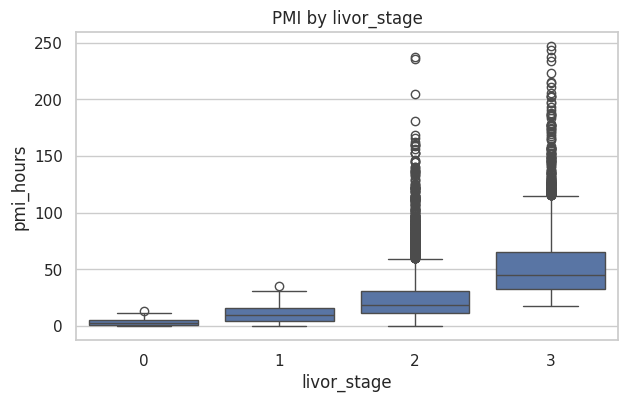

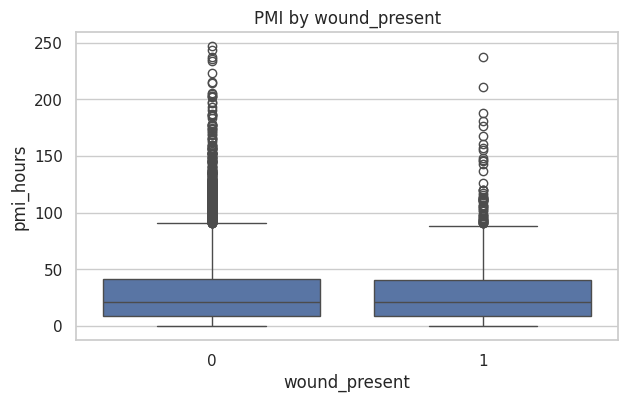

In [ ]:
cat_cols = ["surface_type", "clothing_wet", "rigor_stage", "livor_stage", "wound_present"]
for col in cat_cols:
  plt.figure(figsize=(7,4))
  sns.boxplot(x=col, y="pmi_hours", data=df)
  plt.title(f"PMI by {col}")
  plt.show()

Outlier detection

In [ ]:
# Identify numeric outliers via z-score
from scipy import stats


numeric_cols = [c for c in df.columns if df[c].dtype != "object"]
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outlier_mask = (z_scores > 3).any(axis=1)
outlier_pct = 100 * outlier_mask.mean()
print(f"Outliers detected: {outlier_pct:.2f}% of rows")

# Optionally remove
df_clean = df[~outlier_mask].copy()
print("Dataset after removing outliers:", df_clean.shape)

Outliers detected: 12.22% of rows
Dataset after removing outliers: (8778, 16)


# Feature engineering: PMI bins
 Define categorical bins for PMI

/tmp/ipython-input-2696265046.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="pmi_bin", data=df_clean, palette="viridis")


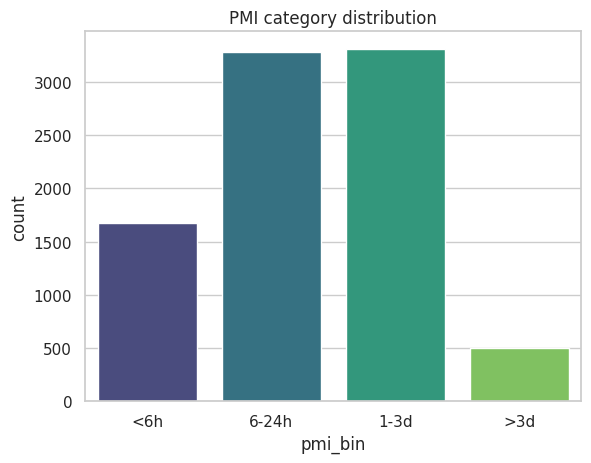

In [ ]:
bins = [0, 6, 24, 72, 240]
labels = ["<6h", "6-24h", "1-3d", ">3d"]
df_clean["pmi_bin"] = pd.cut(df_clean["pmi_hours"], bins=bins, labels=labels, include_lowest=True)


# verify
df_clean["pmi_bin"].value_counts(normalize=True)
sns.countplot(x="pmi_bin", data=df_clean, palette="viridis")
plt.title("PMI category distribution")
plt.show()

# Encode ordinals (rigor/livor)

In [ ]:
# Convert to ordered categories
df_clean["rigor_stage"] = df_clean["rigor_stage"].astype("int")
df_clean["livor_stage"] = df_clean["livor_stage"].astype("int")


# Feature interactions
Pairplot for selected correlated features

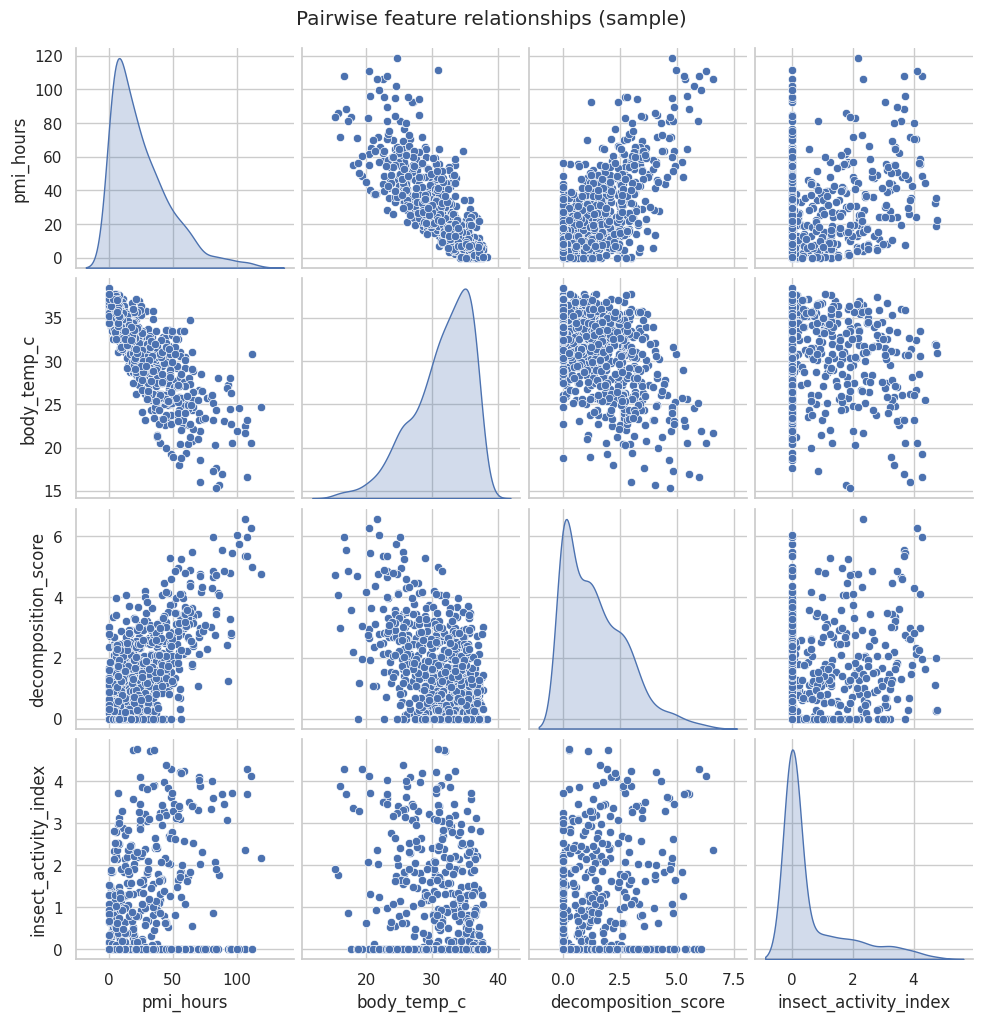

In [ ]:
sample_df = df_clean.sample(800, random_state=RND)
sns.pairplot(sample_df, vars=["pmi_hours","body_temp_c","decomposition_score","insect_activity_index"], diag_kind="kde")
plt.suptitle("Pairwise feature relationships (sample)", y=1.02)
plt.show()

# Save processed dataset

In [ ]:
os.makedirs("data/processed", exist_ok=True)
processed_path = "data/processed/synthetic_pmi_processed.csv"
df_clean.to_csv(processed_path, index=False)
print("Saved processed dataset:", processed_path)

Saved processed dataset: data/processed/synthetic_pmi_processed.csv
